In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sklearn as sk
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [2]:
df = pd.read_csv('../dados/trabalhados/gastos_serie_temporal.csv',parse_dates=['DATA'], index_col=0)
df.rename(columns={'VALOR_REEMBOLSADO': 'VALOR'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4168 entries, 0 to 4167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    4168 non-null   datetime64[ns]
 1   VALOR   4168 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.7 KB


In [3]:
fig = px.scatter(df, x='DATA', y='VALOR', opacity=0.6, trendline='ols')
fig.show()

## Média dos últimos 3 meses

In [4]:
media_3_meses = df.set_index('DATA').rolling('30D').mean()
media_3_meses.reset_index(inplace=True)

In [5]:
fig = px.scatter(media_3_meses, x='DATA', y='VALOR', opacity=0.6, trendline='ols')
fig.show()

In [6]:
fig = go.Figure([
    go.Scatter(x = df['DATA'], y=df['VALOR'], mode='lines', name='Série temporal'),
    go.Scatter(x = media_3_meses['DATA'], y = media_3_meses['VALOR'], mode='lines', name='Média móvel de 3 meses')
])

fig.show()

In [19]:
fig = px.histogram(df, x='VALOR', )
fig.show()

# Modelo ARIMA

In [7]:
adfuller(df['VALOR'])

(-6.658119796485599,
 4.924873538884407e-09,
 30,
 4137,
 {'1%': -3.4319316684000016,
  '5%': -2.862238894316278,
  '10%': -2.5671420277965775},
 99772.21319599925)

Pelo resultado do teste ADF é possível concluir que a série é estacionária, indicando que ela já está pronta para ser usada em um modelo

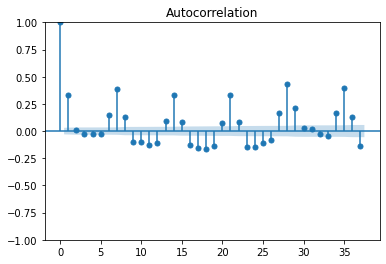

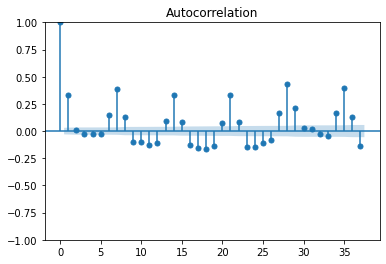

In [8]:
plot_acf(df['VALOR'])


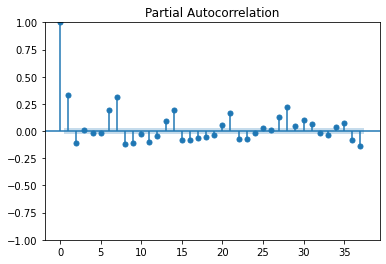

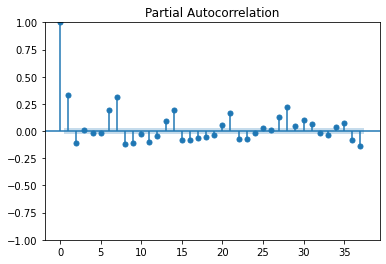

In [12]:
plot_pacf(df['VALOR'], method='ywm')

In [20]:
model = statsmodels.tsa.arima.model.ARIMA(df['VALOR'],
                                            trend ='n',
                                            order = (2, 1, 1))

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALOR   No. Observations:                 4168
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -51037.377
Date:                Tue, 07 Jun 2022   AIC                         102082.754
Time:                        16:07:35   BIC                         102108.094
Sample:                             0   HQIC                        102091.718
                               - 4168                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3503      0.014     24.295      0.000       0.322       0.379
ar.L2         -0.1250      0.018     -6.969      0.000      -0.160      -0.090
ma.L1         -0.9882      0.003   -318.875      0.000      -0.994      -0.982
sigma2      3.095e+09   3.84e-13   8.06e+21      0.000    3.09e+09    3.09e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7665.45
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.96e+36. Standard errors may be unstable.
"""